## Load the Data

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchtext.vocab import GloVe
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pickle
from utils import TextEmotionDataset

In [15]:
import os
import pickle

# Define the base path relative to the notebook's location
base_path = os.getcwd() 

# Paths to your files
tokenizer_path = os.path.join(base_path, 'tokenizer_csv.pkl')
processed_data_path = os.path.join(base_path, 'processed_data_csv.pkl')
label_encoder_path = os.path.join(base_path, 'label_encoder_csv.pkl')

# Loading the files
# Load the tokenizer
with open(tokenizer_path, 'rb') as file:
    tokenizer = pickle.load(file)

# Load the processed data
with open(processed_data_path, 'rb') as file:
    X_train_pad, X_val_pad, X_test_pad, y_train, y_val, y_test, max_seq_length = pickle.load(file)

# Load the label encoder
with open(label_encoder_path, 'rb') as file:
    label_encoder = pickle.load(file)

# Create datasets and dataloaders for training, validation, and testing
train_dataset = TextEmotionDataset(X_train_pad, y_train)
val_dataset = TextEmotionDataset(X_val_pad, y_val)  # Assuming you have a validation dataset
test_dataset = TextEmotionDataset(X_test_pad, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)  # Assuming the same batch size as train_loader
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

## Define the GloVe Embeddings

In [16]:
# GloVe embeddings
vocab_size = len(tokenizer.word_index) + 1
glove = GloVe(name='6B', dim=100)
embedding_matrix = torch.zeros((vocab_size, glove.dim))
for word, index in tokenizer.word_index.items():
    embedding_vector = glove.vectors[glove.stoi[word]] if word in glove.stoi else torch.randn(glove.dim)
    embedding_matrix[index] = embedding_vector

## Define and Instantiate the Model

In [17]:
# Attention module
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.hidden_dim = hidden_dim
        self.main = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 1)
        )

    def forward(self, lstm_output):
        attn_weights = self.main(lstm_output)
        attn_weights = torch.softmax(attn_weights.squeeze(2), dim=1)
        return attn_weights

# EnhancedRNNModel
class EnhancedRNNModel(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, pretrained_embeddings, drop_prob=0.5):
        super(EnhancedRNNModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=False)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob if n_layers > 1 else 0, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(drop_prob)
        self.attention = Attention(hidden_dim * 2)
        self.fc = nn.Linear(hidden_dim * 2, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        attn_weights = self.attention(lstm_out)
        attn_applied = torch.bmm(attn_weights.unsqueeze(1), lstm_out).squeeze(1)
        out = self.dropout(attn_applied)
        out = self.fc(out)
        soft_out = self.softmax(out)
        return soft_out

model = EnhancedRNNModel(vocab_size, len(label_encoder.classes_), 100, 256, 2, embedding_matrix)

# Loss and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [18]:
import torch.nn as nn

def train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10, grad_clip=5.0, patience=3):
    best_val_loss = float('inf')
    patience_counter = 0

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        total_train_correct = 0
        total_train_samples = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, labels)
            total_train_loss += loss.item()

            _, predicted = torch.max(output, 1)
            total_train_correct += (predicted == labels).sum().item()
            total_train_samples += labels.size(0)

            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()

        train_loss = total_train_loss / len(train_loader)
        train_accuracy = total_train_correct / total_train_samples
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        total_val_loss = 0
        total_val_correct = 0
        total_val_samples = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                output = model(inputs)
                val_loss = criterion(output, labels).item()
                total_val_loss += val_loss

                _, predicted = torch.max(output, 1)
                total_val_correct += (predicted == labels).sum().item()
                total_val_samples += labels.size(0)

        val_loss = total_val_loss / len(val_loader)
        val_accuracy = total_val_correct / total_val_samples
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch + 1}/{epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), '/Users/advait/Desktop/gitpositories/SC4001-Assignment-2/Text-Emotion-Recognition/saved_models/att_bi_lstm_te.pth')
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

        scheduler.step()

    return train_losses, val_losses, train_accuracies, val_accuracies

# Train the model with early stopping
train_losses, val_losses, train_accuracies, val_accuracies = train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10, grad_clip=5.0, patience=3)

Epoch 1/10 - Train Loss: 1.9795, Train Accuracy: 0.3170, Val Loss: 1.8790, Val Accuracy: 0.3588
Epoch 2/10 - Train Loss: 1.8105, Train Accuracy: 0.3851, Val Loss: 1.8752, Val Accuracy: 0.3598
Epoch 3/10 - Train Loss: 1.6492, Train Accuracy: 0.4407, Val Loss: 1.9185, Val Accuracy: 0.3473
Epoch 4/10 - Train Loss: 1.4066, Train Accuracy: 0.5301, Val Loss: 2.1500, Val Accuracy: 0.3241
Epoch 5/10 - Train Loss: 1.1239, Train Accuracy: 0.6293, Val Loss: 2.4923, Val Accuracy: 0.3016
Early stopping triggered


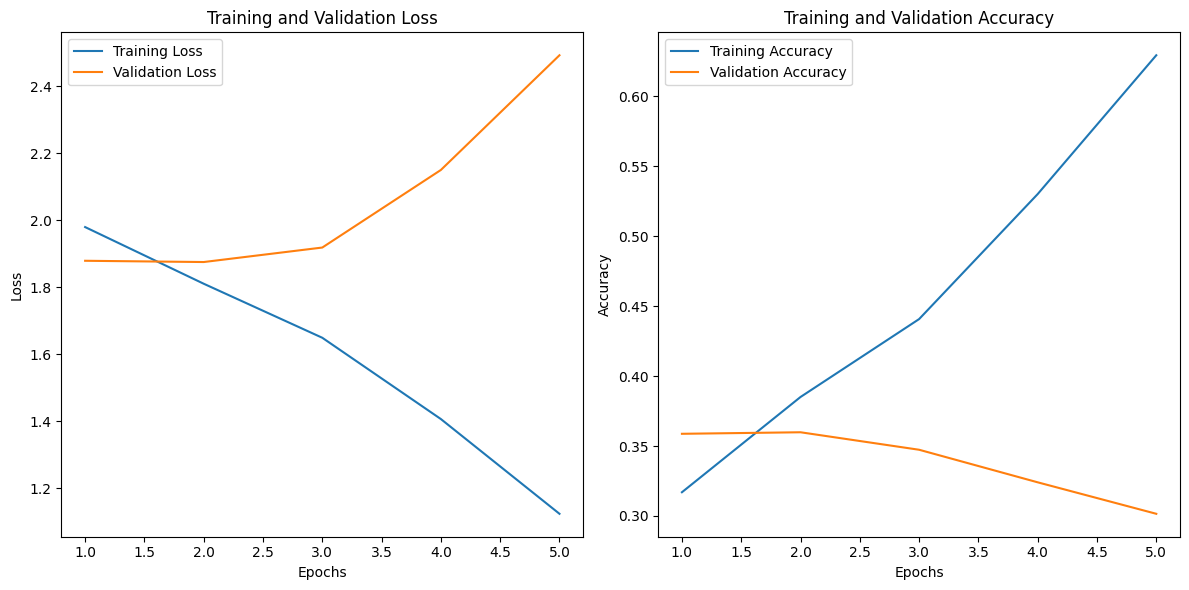

In [21]:
import matplotlib.pyplot as plt

# Plotting
epochs_range = range(1, len(train_losses) + 1)

# Plot for loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot for accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
# Load the best model and evaluate on the validation and test sets
model.load_state_dict(torch.load('/Users/advait/Desktop/gitpositories/SC4001-Assignment-2/Text-Emotion-Recognition/saved_models/att_bi_lstm_te.pth'))

# Evaluation function
def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    true_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            output = model(inputs)
            _, preds = torch.max(output, 1)
            all_preds.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return classification_report(true_labels, all_preds, target_names=label_encoder.classes_)

val_report = evaluate_model(model, val_loader)
print("Validation Report:")
print(val_report)

test_report = evaluate_model(model, test_loader)
print("Test Report:")
print(test_report)


/Users/advait/Desktop/gitpositories/SC4001-Assignment-2/Text-Emotion-Recognition/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/advait/Desktop/gitpositories/SC4001-Assignment-2/Text-Emotion-Recognition/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/advait/Desktop/gitpositories/SC4001-Assignment-2/Text-Emotion-Recognition/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and b

Validation Report:
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        13
     boredom       0.00      0.00      0.00        28
       empty       0.00      0.00      0.00       123
  enthusiasm       0.00      0.00      0.00       126
         fun       0.12      0.05      0.07       263
   happiness       0.31      0.43      0.36       820
        hate       0.32      0.40      0.35       202
        love       0.45      0.45      0.45       609
     neutral       0.41      0.47      0.44      1397
      relief       0.00      0.00      0.00       291
     sadness       0.39      0.24      0.30       838
    surprise       0.17      0.00      0.01       344
       worry       0.33      0.54      0.41      1346

    accuracy                           0.36      6400
   macro avg       0.19      0.20      0.18      6400
weighted avg       0.32      0.36      0.32      6400

Test Report:
              precision    recall  f1-score   s

/Users/advait/Desktop/gitpositories/SC4001-Assignment-2/Text-Emotion-Recognition/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/advait/Desktop/gitpositories/SC4001-Assignment-2/Text-Emotion-Recognition/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/advait/Desktop/gitpositories/SC4001-Assignment-2/Text-Emotion-Recognition/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and b